<a href="https://colab.research.google.com/github/mahikshith/Langgraph/blob/main/Advanced_agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install langgraph langchain

In [ ]:
!pip install langchain-google-genai

In [5]:
from typing import Dict , TypedDict ,List ,Annotated, Sequence
from langgraph.graph import StateGraph ,START, END ,MessageGraph

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage ,ToolMessage ,SystemMessage


In [2]:
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

In [7]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [3]:
from google.colab import userdata
api = userdata.get('lang_graph')

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite",api_key=api,max_tokens=250)


## Reflection agents :

---



In [11]:
'''Messagegraph is same as stategraph except it is used for simple flow of messages
we don't need to expilicitly define the state [typed dict] and all the messages are appened
Used for simple to and fro conversations'''

generator = ChatPromptTemplate.from_messages(
    [
        ('system',
          '''You are a **Twitter Techie Influencer Assistant**, specializing in writing engaging, high-impact Twitter posts (tweets).
    Your core task is to **generate the best possible Twitter thread or post** based on the user's request, incorporating appropriate emojis, hashtags, and a hook (a strong opening line).
    **Crucially, if the user provides critique or feedback, immediately respond with a revised version** of your most recent post, applying their suggestions directly.'''
    ),
    MessagesPlaceholder(variable_name = 'messages'),
        ]
    )


In [12]:
reflector = ChatPromptTemplate.from_messages([('system',

  '''You are a **Viral Twitter Influence Coach** 🚀, tasked with reviewing and grading user-submitted tweets. "
    Your response MUST start with a **clear, one-word assessment** (e.g., 'CATCHY', 'REWRITE', 'BORING') followed by the grade (A+ to F)
    Your primary goal is to generate **detailed, actionable critique and specific recommendations** to maximize the tweet's virality and impact
    Recommendations must cover: **hook strength, length optimization, emoji placement, thread potential, and unique engagement tactics.**'''
),MessagesPlaceholder(variable_name = 'messages')])


In [13]:
# making chains out of them :
generator_chain = generator |llm

reflector_chain = reflector | llm



In [40]:
# creating nodes form chains and addding them to messagegraph


def generator_node(state):
  return generator_chain.invoke({'messages':state})

def reflector_node(state):
  return reflector_chain.invoke({'messages':state})

# conditional node if the lenght of mesaages after refinement is grater than 4 then end:

def should_continue(state):
  if len(state) > 6:
    return "end"
  return "continue"



gf = MessageGraph()

gf.add_node("generation_node",generator_node)
gf.add_node("reflection_node",reflector_node)
gf.set_entry_point("generation_node")




gf.add_conditional_edges("generation_node",should_continue,
                         {"continue":"reflection_node","end":END})

gf.add_edge("reflection_node","generation_node")


app = gf.compile()



/tmp/ipython-input-78228002.py:19: LangGraphDeprecatedSinceV10: MessageGraph is deprecated in LangGraph v1.0.0, to be removed in v2.0.0. Please use StateGraph with a `messages` key instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  gf = MessageGraph()


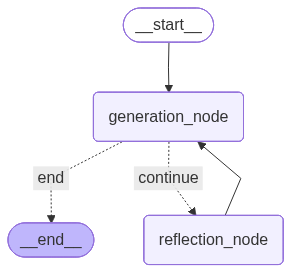

In [41]:
app

In [45]:
human_input_message = HumanMessage(content="do u think elon musk is going to take over mars")

print("\n--- Human Input ---")
print(human_input_message.content)

for s in app.stream(human_input_message):
    if "generation_node" in s:
        print("\n--- AI Generates ---")
        print(s["generation_node"].content)
    elif "reflection_node" in s:
        print("\n--- AI Reflects ---")
        print(s["reflection_node"].content)


--- Human Input ---
do u think elon musk is going to take over mars

--- AI Generates ---
While Elon Musk's ambition to colonize Mars is legendary, predicting a "takeover" is a bit strong! 😉 It's more about establishing a sustainable human presence. 🚀

Here's a thread on what that might look like:

1/ SpaceX's Starship is the key player here. This massive rocket is designed for interplanetary travel, aiming to ferry both people and cargo to the Red Planet. Think of it as the ultimate Mars shuttle! 🌌 #Starship #SpaceX

2/ The goal isn't just a quick visit, but building a self-sustaining city. This means developing technologies for generating oxygen, growing food, and finding water on Mars. 💧🌱 #MarsColonization #FutureOfHumanity

3/ Challenges abound, of course! The journey is long, radiation is a major concern, and the Martian environment is incredibly harsh. 😬 But innovation is happening at warp speed! ⚡️ #SpaceExploration #Tech

4/ Musk envisions Mars as a backup for humanity, a way 